# Jupyter Note - Neural Style Transfer via VGG19

**Author : Hon Wai Ting**

It is an example from the book **Mastering PyTorch** integrated some code from [PyTorch official tutorial](https://docs.pytorch.org/tutorials/advanced/neural_style_tutorial.html).

# Import packages & Create directories

In [1]:
import sys
import os

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

dvc = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print Device and Library Version
print(f"Using device: {dvc}")
print(f"Python version={sys.version}")
print(f"torch version={torch.__version__}")
print(f"torchvision version={torchvision.__version__}")
print(f"matplotlib version={matplotlib.__version__}")

# Create Directory
INPUT_PATH="./inputs"
OUTPUT_PATH="./outputs"
CONFIG_PATH="./config"
os.makedirs(INPUT_PATH, exist_ok=True) # Input Directory
os.makedirs(OUTPUT_PATH, exist_ok=True) # Output Directory
os.makedirs(CONFIG_PATH, exist_ok=True) # Model Config Directory

Using device: cpu
Python version=3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:50:49) [Clang 16.0.6 ]
torch version=2.5.1
torchvision version=0.20.1
matplotlib version=3.10.0


# Google Drive Setup

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Change the current working directory
os.chdir("/content/drive/MyDrive/Colab/Neural Style Transfer")
print(os.getcwd())

/content/drive/MyDrive/Colab/Neural Style Transfer


# Define the model aritechture for our task

## Import Pretrained model VGG19

In [2]:
vgg19_model = torchvision.models.vgg19(weights=torchvision.models.vgg.VGG19_Weights.DEFAULT)
print(vgg19_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Build Our Own Architecture

In [3]:
# Keep Feature Extract Part Only
vgg19_model = vgg19_model.features

# desired depth layers to compute style/content losses :
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

model = nn.Sequential()

i = 0;
for layer in vgg19_model.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

# now we trim off the layers after the last content and style losses
for i, (name, layer) in enumerate(model.named_children(), 1):
    if name == max(style_layers):
        break

model = model[:(i)]

In [4]:
# Display and save the defined model
print(model)
torch.save(model, f"{CONFIG_PATH}/model.pth") # Save the entire model

Sequential(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


# Inference

## Import our model from local directory

In [5]:
# Load Model from pth
neural_style_transfer_model = torch.load(f"{CONFIG_PATH}/model.pth", weights_only=False, map_location=dvc)

# Disable Gradient and Turn Model to Evaluation Model
neural_style_transfer_model.requires_grad_(False)
neural_style_transfer_model.eval()
neural_style_transfer_model.to(dvc)

Sequential(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

## Import Content and Style Images

Original image size: (1264, 1264)
New image size: (1264, 1264)
Original image size: (524, 502)
New image size: (502, 502)
style_image.shape: torch.Size([1, 3, 128, 128])
content_image.shape: torch.Size([1, 3, 128, 128])


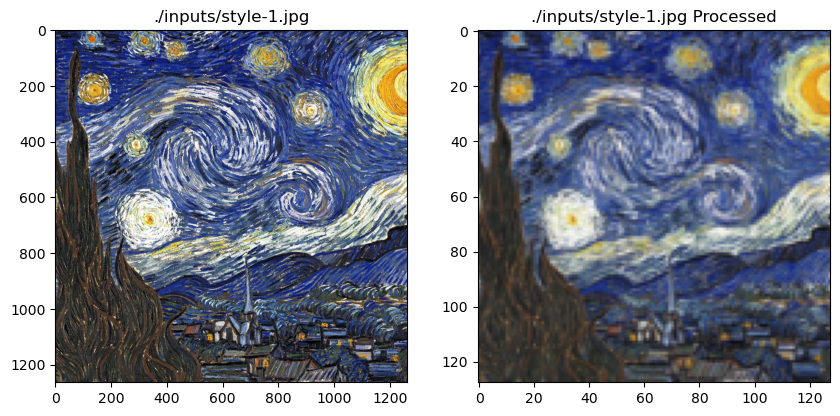

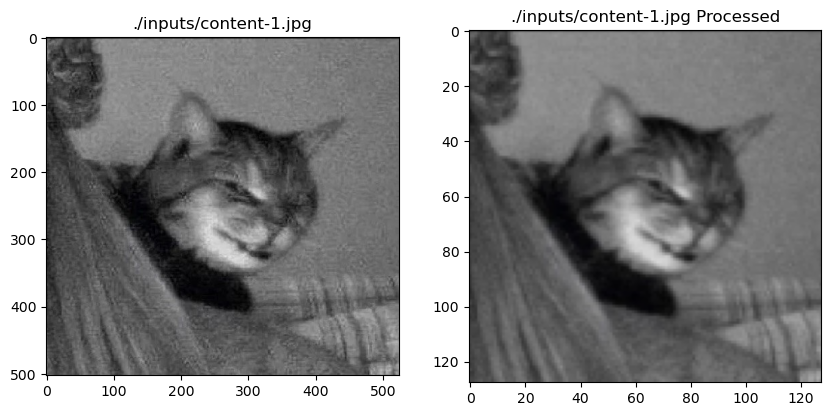

In [8]:
BIG_DIM=512
SMALL_DIM=128
image_dimension = BIG_DIM if torch.cuda.is_available() else SMALL_DIM

def image_to_tensor(image_filepath, image_dimension=SMALL_DIM):
    img = Image.open(image_filepath).convert('RGB')

    print(f"Original image size: {img.size}")

    # display image to check
    fig, axs = plt.subplots(1,2, figsize=(10, 6))
    axs[0].set_title(f"{image_filepath}")
    axs[0].imshow(img)

    # Central-crop the image if it is not square
    if img.height != img.width:
        width, height = img.size
        min_dim = min(width, height)
        left = (width - min_dim) / 2
        top = (height - min_dim) / 2
        right = (width + min_dim) / 2
        bottom = (height + min_dim) / 2
        box = (left, top, right, bottom)
        img = img.crop(box)

    # Scale-up image if it is too small
    if img.height < image_dimension or img.width < image_dimension:
      scaling_factor = image_dimension / max(img.size)

      new_width = int(img.width * scaling_factor)
      new_height = int(img.height * scaling_factor)

      img = img.resize((new_width, new_height), Image.LANCZOS)

    print(f"New image size: {img.size}")

    torch_transformation = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_dimension),
        torchvision.transforms.ToTensor()
    ])

    img = torch_transformation(img).unsqueeze(0)

    # Display Processed Image, Sub plt
    axs[1].set_title(f"{image_filepath} Processed")
    axs[1].imshow(img.squeeze(0).cpu().detach().numpy().transpose(1,2,0))

    return img.to(torch.float)



style_image = image_to_tensor(f"{INPUT_PATH}/style-1.jpg", image_dimension).to(dvc)
content_image = image_to_tensor(f"{INPUT_PATH}/content-1.jpg", image_dimension).to(dvc)
print(f"style_image.shape: {style_image.shape}")
print(f"content_image.shape: {content_image.shape}")

## Define input tensor

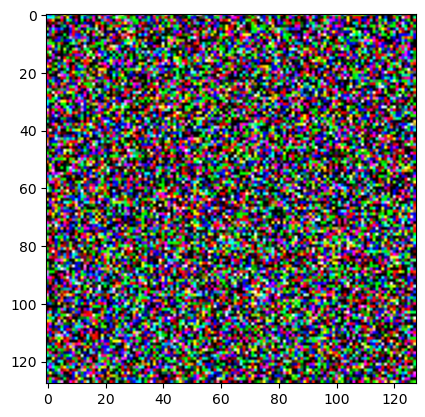

In [16]:
# initialize as the content image
# ip_image = content_image.clone().to(dvc)

# initialize as random noise:
ip_image = torch.randn(content_image.data.size(), device=dvc)

plt.figure()
plt.imshow(ip_image.squeeze(0).cpu().detach().numpy().transpose(1,2,0).clip(0,1));

## Inference Pipeline

### Define Functions and Variables before inference

In [10]:
# Define Normalisation Layer
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(dvc)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(dvc)

def normalise(x):
    return (x - cnn_normalization_mean.view(-1, 1, 1)) / cnn_normalization_std.view(-1, 1, 1)

In [11]:
# Define gram matrix
def gram_matrix(ip):
    num_batch, num_channels, height, width = ip.size()
    feats = ip.view(num_batch * num_channels, width * height)
    gram_mat = torch.mm(feats, feats.t())
    return gram_mat.div(num_batch * num_channels * width * height)

In [12]:
# desired depth layers to compute style/content losses :
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

### Do it

epoch number 50
style loss = 1022.6057739257812, content loss = 64.52811431884766
epoch number 100
style loss = 69.47782135009766, content loss = 36.184696197509766
epoch number 150
style loss = 5.920085906982422, content loss = 24.701202392578125
epoch number 200
style loss = 3.1229074001312256, content loss = 18.184547424316406
epoch number 250
style loss = 2.451735496520996, content loss = 15.381467819213867
epoch number 300
style loss = 2.2234177589416504, content loss = 14.040818214416504
epoch number 350
style loss = 2.1256000995635986, content loss = 13.356050491333008
epoch number 400
style loss = 2.0819053649902344, content loss = 12.976848602294922
epoch number 450
style loss = 2.0487489700317383, content loss = 12.749266624450684
epoch number 500
style loss = 2.0261244773864746, content loss = 12.585387229919434
epoch number 550
style loss = 2.0045132637023926, content loss = 12.462494850158691
epoch number 600
style loss = 1.9966059923171997, content loss = 12.3596973419189

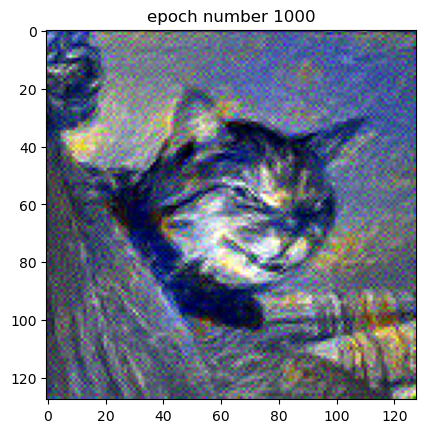

epoch number 1050
style loss = 2.000354528427124, content loss = 12.079792022705078
epoch number 1100
style loss = 21.982864379882812, content loss = 18.918399810791016
epoch number 1150
style loss = 2.8281166553497314, content loss = 14.511849403381348
epoch number 1200
style loss = 2.1553080081939697, content loss = 12.643723487854004


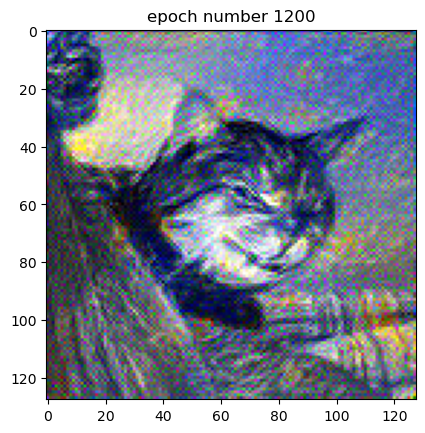

CPU times: user 33min 36s, sys: 2min 5s, total: 35min 42s
Wall time: 7min 22s


In [17]:
%%time
ip_image.requires_grad_()
num_epochs= 4000 if torch.cuda.is_available() else 1200
wt_style=1e4
wt_content=1
epoch_style_losses = []
epoch_content_losses = []
opt = optim.LBFGS([ip_image], lr=0.05)
loss_checkpoint_step = 50
image_checkpoint_step = 200

for curr_epoch in range(1, num_epochs+1):

    ip_image.data.clamp_(0, 1)
    opt.zero_grad()

    epoch_style_loss = 0
    epoch_content_loss = 0

    x = ip_image
    c = content_image
    s = style_image

    x = normalise(x)
    c = normalise(c)
    s = normalise(s)

    for name, layer in neural_style_transfer_model.named_children():
        x = layer(x)
        c = layer(c).detach()
        s = layer(s).detach()
        if name in content_layers:
             epoch_content_loss+= F.mse_loss(x, c.detach())
        if name in style_layers:
             epoch_style_loss += F.mse_loss(gram_matrix(x), gram_matrix(s).detach())

    epoch_style_loss *= wt_style
    epoch_content_loss *= wt_content

    total_loss = epoch_style_loss + epoch_content_loss
    total_loss.backward()

    def closure():
        return epoch_style_loss + epoch_content_loss

    if curr_epoch % loss_checkpoint_step == 0:
        epoch_style_losses += [epoch_style_loss.cpu().detach().numpy()]
        epoch_content_losses += [epoch_content_loss.cpu().detach().numpy()]
        print(f"epoch number {curr_epoch}")
        print(f"style loss = {epoch_style_loss}, content loss = {epoch_content_loss}")

    if curr_epoch >= 1000 and curr_epoch % image_checkpoint_step == 0:
        display_image = ip_image.data.clamp_(0, 1).squeeze(0).cpu().detach()
        plt.figure()
        plt.title(f"epoch number {curr_epoch}")
        plt.imshow(display_image.numpy().transpose(1,2,0))
        plt.show()
        torchvision.utils.save_image(
            display_image,
            f"{OUTPUT_PATH}/image_{curr_epoch}.jpg"
        )

    opt.step(closure=closure)

## Plot Loss Curve

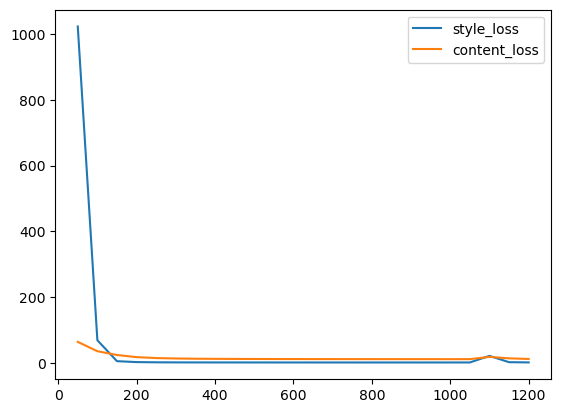

In [18]:
plt.plot(range(loss_checkpoint_step, num_epochs+1, loss_checkpoint_step), epoch_style_losses, label='style_loss');
plt.plot(range(loss_checkpoint_step, num_epochs+1, loss_checkpoint_step), epoch_content_losses, label='content_loss');
plt.legend();

# Foundings
- For style image, it must have very strong colour theme
- Gradient Explode

ToDos:
- Make it deployable

